## <center>Plotly plot of a circular phylogenetic tree <br>Interactive path marking</center>  ##

A circular phylogenetic tree is defined as the image of a rectangular tree, through a map $g$, that associates
to each point of cartesian coordinates (x,y), a point of special  polar coordinates $(r,\theta)$, with respect to the `tree.root` as  reference point, and the horizontal axis through this point as  reference direction.

The Plotly plot generation of a phylogenetic tree with  rectangular layout is presented in this [Jupyter Notebook](http://nbviewer.jupyter.org/github/empet/Phylogenetic-trees/blob/master/Plotly-rectangular-phylogram-Zika.ipynb). The cartesian coordinates on the rectangular representation are assigned as in Biopython [https://github.com/biopython/biopython/blob/master/Bio/Phylo/_utils.py](https://github.com/biopython/biopython/blob/master/Bio/Phylo/_utils.py).


If `ymin`, `ymax` are the min, max y-coordinates on the rectangular  tree, d is the distance between the y-coordinates of two consecutive leafs, then the  mapping from cartesian to polar coordinates is defined as follows:
$$(x,y)\mapsto (r=x, \:\theta=2\pi (y-ymin+d)/(ymax-ymin+d))$$


When  the tree has a reduced number of leafs, we can choose to map the rectangular representation onto a circular
area between some `startangle>=0`, and `endangle`<$2\pi$. In this case the mapping to polar coordinates is defined
by:
$$(x,y)\mapsto (r=x,\: \theta=(endangle-startangle)(y-ymin)/(ymax-ymin))$$

Let us illustrate this mapping on the basic rectangular tree below, where  $x_{left}=x_{right}$:

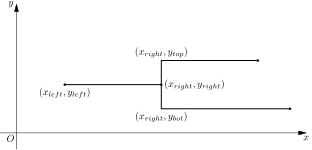

In [1]:
from IPython.display import SVG
SVG(filename='Data/recttree.svg')

Denoting  $\theta=g(y_{right})$, $\theta_b=g(y_{bot})$, and $\theta_t=g(y_{top})$, the circular image of this rectangular tree looks like this one:

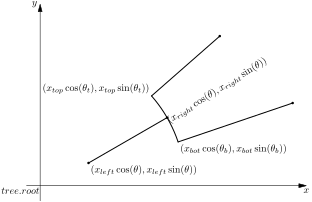

In [2]:
SVG(filename='Data/circtree.svg')

The function `get_circular_tree_data()` computes and returns the lists of x, y-coordinates (with
$x=r\cos{\theta}, y=r\sin{\theta}$) of the points  on the circular  phylogenetic tree.

In [22]:
import platform
print(f'Python version: {platform.python_version()}')
import plotly
print(f"Plotly version: {plotly.__version__}")

Python version: 3.6.4
Plotly version: 3.3.0


In [3]:
from Bio import Phylo
import numpy as np
import plotly.graph_objs as go
import ipywidgets as ipw

In [4]:


def get_circular_tree_data(tree, order='level', dist=1, start_angle=0, end_angle=360, start_leaf='first'):
    """Define  data needed to get the Plotly plot of a circular tree
    """
    # tree:  an instance of Bio.Phylo.Newick.Tree or Bio.Phylo.PhyloXML.Phylogeny
    # order: tree  traversal method to associate polar coordinates to its nodes
    # dist:  the vertical distance between two consecutive leafs in the associated rectangular tree layout
    # start_angle:  angle in degrees representing the angle of the first leaf mapped to a circle
    # end_angle: angle in degrees representing the angle of the last leaf
    # the list of leafs mapped in anticlockwise direction onto circles can be tree.get_terminals() 
    # or its reversed version tree.get_terminals()[::-1]. 
    # start leaf: is a keyword with two possible values"
    # 'first': to map  the leafs in the list tree.get_terminals() onto a circle,
    #         in the counter-clockwise direction
    # 'last': to map  the leafs in the  list, tree.get_terminals()[::-1] 
    
    start_angle *= np.pi/180 # conversion to radians
    end_angle *= np.pi/180
    
    def get_radius(tree):
        """
        Associates to  each clade root its radius, equal to the distance from that clade to the tree root
        returns dict {clade: node_radius}
        """
        node_radius = tree.depths()
        
        #  If the tree did not record  the branch lengths  assign  the unit branch length
        #  (ex: the case of a newick tree "(A, (B, C), (D, E))")
        if not np.count_nonzero(node_radius.values()):
            node_radius = tree.depths(unit_branch_lengths=True)
        return node_radius
   
    
    def get_vertical_position(tree):
        """
        returns a dict {clade: ycoord}, where y-coord is the cartesian y-coordinate 
        of a  clade root in a rectangular phylogram
        
        """
        n_leafs = tree.count_terminals() # Counts the number of tree leafs.
        
        # Assign y-coordinates to the tree leafs
        if start_leaf == 'first':
            node_ycoord = dict((leaf, k) for k, leaf in enumerate(tree.get_terminals()))
        elif start_leaf == 'last':
            node_ycoord = dict((leaf, k) for k, leaf in enumerate(reversed(tree.get_terminals())))
        else:
            raise ValueError("start leaf can be only 'first' or 'last'")
            
        def assign_ycoord(clade):#compute the y-coord for the root of this clade
            for subclade in clade:
                if subclade not in node_ycoord: # if the subclade root hasn't a y-coord yet
                    assign_ycoord(subclade)
            node_ycoord[clade] = 0.5 * (node_ycoord[clade.clades[0]] + node_ycoord[clade.clades[-1]])

        if tree.root.clades:
            assign_ycoord(tree.root)
        return node_ycoord

    node_radius = get_radius(tree)
    node_ycoord = get_vertical_position(tree)
    y_vals = node_ycoord.values()
    ymin, ymax = min(y_vals), max(y_vals)
    ymin -= dist # this dist subtraction is necessary to avoid coincidence of the  first and last leaf angle
                 # when the interval  [ymin, ymax] is mapped onto [0, 2pi],
                
    def ycoord2theta(y):
        # maps an y in the interval [ymin-dist, ymax] to the interval [radian(start_angle), radian(end_angle)]
        
        return start_angle + (end_angle - start_angle) * (y-ymin) / float(ymax-ymin)

    
        

    def get_points_on_lines(linetype='radial', x_left=0, x_right=0, y_right=0,  y_bot=0, y_top=0):
        """
        - define the points that generate a radial branch and the circular arcs, perpendicular to that branch
         
        - a circular arc (angular linetype) is defined by 10 points on the segment of ends
        (x_bot, y_bot), (x_top, y_top) in the rectangular layout,
         mapped by the polar transformation into 10 points that are spline interpolated
        - returns for each linetype the lists X, Y, containing the x-coords, resp y-coords of the
        line representative points
        """
       
        if linetype == 'radial':
            theta = ycoord2theta(y_right) 
            X = [x_left*np.cos(theta), x_right*np.cos(theta), None]
            Y = [x_left*np.sin(theta), x_right*np.sin(theta), None]
        
        elif linetype == 'angular':
            theta_b = ycoord2theta(y_bot)
            theta_t = ycoord2theta(y_top)
            t = np.linspace(0,1, 10)# 10 points that span the circular arc 
            theta = (1-t) * theta_b + t * theta_t
            X = list(x_right * np.cos(theta)) + [None]
            Y = list(x_right * np.sin(theta)) + [None]
        
        else:
            raise ValueError("linetype can be only 'radial' or 'angular'")
       
        return X,Y   
        
    

    def get_line_lists(clade,  x_left,  xlines, ylines, xarc, yarc):
        """Recursively compute the lists of points that span the tree branches"""
        
        # xlines, ylines  - the lists of x-coords, resp y-coords of radial edge ends
        # xarc, yarc - the lists of points generating arc segments for tree branches
        
        x_right = node_radius[clade]
        y_right = node_ycoord[clade]
   
        X,Y = get_points_on_lines(linetype='radial', x_left=x_left, x_right=x_right, y_right=y_right)
   
        xlines.extend(X)
        ylines.extend(Y)
   
        if clade.clades:
           
            y_top = node_ycoord[clade.clades[0]]
            y_bot = node_ycoord[clade.clades[-1]]
       
            X,Y = get_points_on_lines(linetype='angular',  x_right=x_right, y_bot=y_bot, y_top=y_top)
            xarc.extend(X)
            yarc.extend(Y)
       
            # get and append the lists of points representing the  branches of the descedants
            for child in clade:
                get_line_lists(child, x_right, xlines, ylines, xarc, yarc)

    xlines = []
    ylines = []
    xarc = []
    yarc = []
    get_line_lists(tree.root,  0, xlines, ylines, xarc, yarc)  
    xnodes = []
    ynodes = []

    for clade in tree.find_clades(order='preorder'): #it was 'level'
        theta = ycoord2theta(node_ycoord[clade])
        xnodes.append(node_radius[clade]*np.cos(theta))
        ynodes.append(node_radius[clade]*np.sin(theta))
        
    return xnodes, ynodes,  xlines, ylines, xarc, yarc    

### A circular phylogram from a `'phyloxml'` file

Read a phylogenetic tree from a [phyloxml file](http://phyloxml.org/) 

In [5]:
tree = Phylo.read('Data/bcl_2.xml', 'phyloxml')

Assign an id to each tree node: 

In [6]:
traverse_order = 'preorder'

all_clades=list(tree.find_clades(order=traverse_order))
for k in range(len((all_clades))):
    all_clades[k].id=k

Get the coordinates for  the nodes and links, as linear and circular lines, that define the Plotly traces
representing the phylogram:

In [7]:
xnodes, ynodes,  xlines, ylines, xarc, yarc = get_circular_tree_data(tree, order=traverse_order, start_leaf='last')

In the next cell  we are performing a particular processing that is dictated by the type of  data provided for each tree node 
in the `phyloxml` file.

More precisely, we are extracting the text to be displayed on hover over the tree nodes, and the confidence values to be mapped to  a  colorscale. 


In [8]:
tooltip=[]
color=[]
for clade in tree.find_clades(order=traverse_order):
    if clade.name and clade.confidence and clade.branch_length:
        tooltip.append(f"id: {clade.id}<br>name: {clade.name}<br>branch-length: {clade.branch_length}\
                    <br>confidence: {int(clade.confidence.value)}")
        color.append[clade.confidence.value]
    elif clade.name is None and clade.branch_length is not None and clade.confidence is not None: 
        color.append(clade.confidence.value)
        tooltip.append(f"id: {clade.id}<br>branch-length: {clade.branch_length}\
                    <br>confidence: {int(clade.confidence.value)}")
    elif clade.name and clade.branch_length and clade.confidence is None:
        tooltip.append(f"id: {clade.id}<br>name: {clade.name}<br>branch-length: {clade.branch_length}")
        color.append(-1)
    else: 
        tooltip.append('')
        color.append(-1)

size=[9  if c!=-1 else 7 for c in color]

In [9]:
pl_colorscale=[[0.0, 'rgb(10,10,150)'],#color for leafs that haven't associated a confidence
               [0.001, 'rgb(10,10,150)'],
               [0.001, 'rgb(214, 47, 38)'],   # in fact the colorscale starts here          
               [0.1, 'rgb(214, 47, 38)'],
               [0.2, 'rgb(244, 109, 67)'],
               [0.3, 'rgb(252, 172, 96)'],
               [0.4, 'rgb(254, 224, 139)'],
               [0.5, 'rgb(254, 254, 189)'],
               [0.6, 'rgb(217, 239, 139)'],
               [0.7, 'rgb(164, 216, 105)'],
               [0.8, 'rgb(102, 189, 99)'],
               [0.9, 'rgb(63, 170, 89)'],              
               [1.0, 'rgb(25, 151, 79)']]
 

Define data and layout for the Plotly plot of our circular phylogram:

In [10]:
trace_nodes=dict(type='scatter',
           x=xnodes,
           y= ynodes, 
           mode='markers',
           marker=dict(color=color,
                       size=size, colorscale=pl_colorscale, 
                       colorbar=dict(thickness=20, dtick=10, ticklen=4, title='confidence')),
           text=tooltip, 
           hoverinfo='text',
           opacity=1)

trace_radial_lines=dict(type='scatter',
                       x=xlines,
                       y=ylines, 
                       mode='lines',
                       line=dict(color='rgb(20,20,20)', width=1),
                       hoverinfo='none')

trace_arcs=dict(type='scatter',
                       x=xarc,
                       y=yarc,
                       mode='lines',
                       line=dict(color='rgb(20,20,20)', width=1, shape='spline'),
                       hoverinfo='none')

In [12]:
layout=dict(title='Bcl-2 gene family tree',
            font=dict(family='Balto',size=14),
            width=700,
            height=750,
            autosize=False,
            showlegend=False,
            xaxis=dict(visible=False),
            yaxis=dict(visible=False), 
            hovermode='closest',
            plot_bgcolor='rgb(245,245,245)',
            margin=dict(t=75)
           )

### 1. Plotly plot of the circular phylogram

In [13]:
fig=go.FigureWidget(data=[trace_radial_lines, trace_arcs, trace_nodes], layout=layout)

In [14]:
import plotly.plotly as py
py.sign_in('empet', '')
py.iplot(fig, filename='bcl2-phyloxml')

### 2. Interactive path marking from root to an arbitrary tree node

In [15]:
fw=go.FigureWidget(fig)
with fw.batch_update():
    fw.data[2].marker.showscale=False
    fw.layout.title='Path marking from root to a tree node by clicking that node'

In [16]:
textarea_box = ipw.Textarea(value='',
                   description='',
                   disabled=False,
                   continuous_update=True)

textarea_box.layout = dict(margin='-70px 10px 10px 80px', width='540px') 

In [17]:
def select_path_nodes(trace, points, state):
    
    if not points.point_inds:
            return
    ind = points.point_inds[0]    
    new_color = np.array(['rgb(150, 160, 150)']*len(trace.x)) 
    path=tree.get_path(id=ind)
    path_ids=[0]+[path[k].id for k in range(len(path))]
    new_color[path_ids] = 'magenta'
    trace.marker.color = new_color 
    target_node=list(tree.find_elements(id=ind))[0]
    path_to=target_node.name if target_node.name else 'noname'
    textarea_box.value = ' '.join(f" {x} ->" for x in path_ids[:-1])+ f"{path_ids[-1]} ({path_to})" 

In [18]:
fw.data[2].on_click(select_path_nodes) 
ipw.VBox([fw, textarea_box])

    'data': [{'hoverinfo': 'none',
              'line': {'color': 'rgb(20,20,20…

In [19]:
from IPython.core.display import HTML
def  css_styling():
    styles = open("./custom.css", "r").read()
    return HTML(styles)
css_styling()